# **Tensor Network: Quantum-Motivated Classical Machine Learning**

In this project, we utilized tensor networks to enhance the performance of quantum computers. A tensor network is a technique used to handle complex computations by decomposing high-dimensional tensors into lower-dimensional ones.

Originally, tensor networks were introduced as a classical limitation that quantum computers must overcome. However, in this project, we leveraged these characteristics to train initial parameters for QAOA (Quantum Approximate Optimization Algorithm) with minimal resources. Subsequently, the learned parameters were used to improve the performance of quantum QAOA and further enhance the methods discussed in the RL QAOA phase.






## **Quantum Layer Training Using Tensor Networks**


### **1. Example graph**

In this step, each edge and weight are randomly generated within a range similar to the problem domain.

A QAOA layer that is easy to train with tensor networks follows a **tree structure**. According to [this reference](https://arxiv.org/pdf/1908.08862), tree structures allow for stable contraction of tensors without the risk of exponential growth, enabling efficient QAOA training.

This advantage not only allows tensor networks to accurately approximate quantum circuits but also provides a unique strength: unlike quantum circuits, tensor networks do not require sampling. 

Therefore, even if high-performance QPUs (Quantum Processing Units) become available in the future, tensor networks will continue to provide polynomial benefits by enabling computation without the need for sampling.

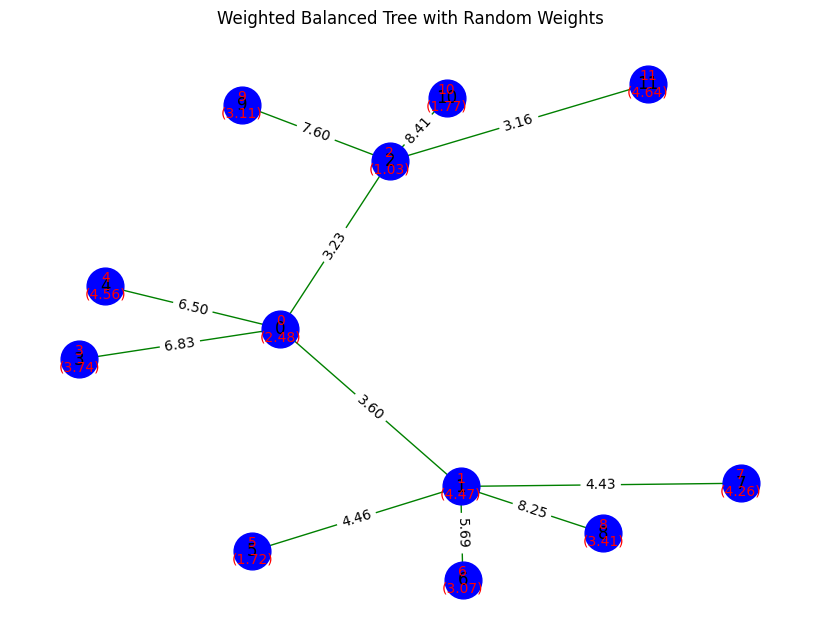

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def generate_weighted_balanced_tree(n, min_degree=3, node_weight_range=(0, 1), edge_weight_range=(0, 1)):
    """
    Generates a balanced tree graph with n nodes, where each node has at least min_degree connections.
    Assigns random weights to nodes and edges.

    Parameters
    ----------
    n : int
        Number of nodes in the tree.
    min_degree : int, optional (default=3)
        Minimum number of connections each node should have.
    node_weight_range : tuple, optional
        Range of weights to assign to nodes (default=(1, 10)).
    edge_weight_range : tuple, optional
        Range of weights to assign to edges (default=(1, 10)).

    Returns
    -------
    tree : networkx.Graph
        A randomly generated balanced tree with n nodes and assigned weights.
    adjacency_matrix : np.ndarray
        The adjacency matrix representing the tree with node and edge weights.
    node_weights : dict
        Dictionary of nodes with assigned weights.
    """

    # Create an empty graph
    tree = nx.Graph()
    tree.add_node(0)
    node_count = 1
    current_level = [0]  # Start from root

    while node_count < n:
        next_level = []
        for node in current_level:
            for _ in range(min_degree):
                if node_count < n:
                    tree.add_node(node_count)
                    tree.add_edge(node, node_count, weight=random.uniform(*edge_weight_range))
                    next_level.append(node_count)
                    node_count += 1
        current_level = next_level

    # Assign random weights to nodes
    node_weights = {node: random.uniform(*node_weight_range) for node in tree.nodes()}

    # Create the adjacency matrix with edge weights
    adjacency_matrix = nx.to_numpy_array(tree, weight='weight')

    # Add node weights to the diagonal
    np.fill_diagonal(adjacency_matrix, list(node_weights.values()))

    # Combine upper and lower triangles since edge weights should be symmetric
    adjacency_matrix = np.triu(adjacency_matrix)

    return tree, adjacency_matrix, node_weights

def visualize_weighted_tree(tree, node_weights, title="Weighted Balanced Tree"):
    """
    Visualizes the generated balanced tree with node and edge weights.

    Parameters
    ----------
    tree : networkx.Graph
        The tree to visualize.
    node_weights : dict
        The node weights for visualization.
    title : str, optional
        The title of the graph plot.
    """
    pos = nx.spring_layout(tree)
    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, node_color='blue', edge_color='green', node_size=700, font_size=12)
    edge_labels = nx.get_edge_attributes(tree, 'weight')
    nx.draw_networkx_edge_labels(tree, pos, edge_labels={(u, v): f'{w:.2f}' for u, v, w in tree.edges(data='weight')})
    node_labels = {node: f"{node}\n({node_weights[node]:.2f})" for node in tree.nodes()}
    nx.draw_networkx_labels(tree, pos, labels=node_labels, font_size=10, font_color="red")
    plt.title(title)
    plt.show()

# Example usage
n = 12  # Number of nodes
tree_graph, adj_matrix, node_weights = generate_weighted_balanced_tree(n, min_degree=4, node_weight_range=(1, 5), edge_weight_range=(1, 10))

# Visualize the generated balanced tree with weights
visualize_weighted_tree(tree_graph, node_weights, "Weighted Balanced Tree with Random Weights")





## **2. Tensor Training**

Instead of training a single graph generated by the tensor network using Tensor QAOA, the goal is to find parameters that generalize effectively across multiple graphs. This approach enables the extraction of a reasonable warm-up state.

According to [this reference](https://arxiv.org/pdf/1908.08862), the paper suggests that as long as the problem type remains unchanged, the optimal parameters do not significantly vary, even if the size or shape of the graph is distorted. 

Additionally, during RL QAOA, it has been experimentally confirmed that achieving a state with a sufficiently guaranteed low state, rather than the perfect optimal value of QAOA, leads to improved performance. Therefore, such a warm-up can greatly assist RL QAOA in the learning process.




In [2]:
def generate_complete_graph_with_random_weights(n, 
                                               node_weight_min=-3, node_weight_max=3,
                                               edge_weight_min=-3, edge_weight_max=3,
                                               seed=42,
                                               integer_weights=True):
    """
    Generates a complete graph with `n` nodes and assigns random weights 
    in the range [-3, 3] (or specified range) to each node and edge.
    """
    rs = np.random.RandomState(seed)
    G = nx.complete_graph(n)  # Create a complete graph

    # Assign random weights to nodes
    for node in G.nodes():
        if integer_weights:
            weight_val = rs.uniform(node_weight_min, node_weight_max+1)
        else:
            weight_val = rs.uniform(node_weight_min, node_weight_max)
        # Store 'node_weight' as a node attribute (not used in RQAOA but for reference)
        G.nodes[node]['node_weight'] = weight_val
    
    # Assign random weights to edges
    for u, v in G.edges():
        if integer_weights:
            weight_val = rs.uniform(edge_weight_min, edge_weight_max+1)
        else:
            weight_val = rs.uniform(edge_weight_min, edge_weight_max)
        # Store 'weight' as an edge attribute (this is the field used in RQAOA)
        G[u][v]['weight'] = weight_val

    return G


In [17]:
import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize
from RL_QAOA import *
import random
# Define QAOA depth
depth = 1
size = 8
seed = 50

# Generate a QUBO matrix that is challenging for classical QAOA optimization
np.random.seed(seed)
Q = generate_upper_triangular_qubo(size, -3, 3, integer=False)

print(Q)
param_list = []
start = 3

while start <= size:

    graph_list = []

    # 1. Generate 10 different tensor network-friendly quadratic matrices 
    # for general training (size ranging from n_c to n)
    for i in range(10):
        tree_graph, adj_matrix, node_weights = generate_weighted_balanced_tree(
            start, min_degree=3, node_weight_range=(-3, 3), edge_weight_range=(-3, 3)
        )
        graph_list.append(adj_matrix)
    # 2. Optimize the generated matrices classically using the SLSQP optimizer 
    # to quickly find near-optimal parameters
    qaoa = QAOA_layer(depth=depth, Q=adj_matrix)
    if len(param_list) == 0:
        init_params = np.random.uniform(-0.5, 0.5, 2 * depth)
        print(init_params)
    else:
        init_params = param_list[-1]
        print(init_params)
    
    index = 0
    def QAOA_tensor_res(param):
        """
        Computes the total expectation value for all generated graphs.

        Args:
            param (np.ndarray): QAOA parameters (gammas and betas).

        Returns:
            float: Sum of expectation values across all graphs.
        """
        res = 0
        for graph in graph_list:
            qaoa = QAOA_layer(depth=depth, Q=np.array(graph))
            @qml.qnode(qaoa.dev)
            def qaoa_expectation(params):
                """
                Quantum node that runs the QAOA circuit and measures the expectation value
                of the cost Hamiltonian.

                Args:
                    params (np.ndarray): Array of QAOA parameters (gammas and betas).

                Returns:
                    float: Expectation value of the cost Hamiltonian.
                """
                qaoa.qaoa_circuit(params)
                return qml.expval(qaoa.ham)
            res += qaoa_expectation(param)
        return res
    
    # Perform optimization using SLSQP
    bounds = [(-np.pi, np.pi) for _ in init_params]
    result = minimize(QAOA_tensor_res, init_params, method="SLSQP", options={'maxiter': 1000},bounds=bounds)
    param = result.x

    # 3. Extract the optimized parameters and use them as initial values 
    # for the next optimization iteration
    print(result)
    param = result.x
    min_cost = result.fun
    param_list.append(param)

    # Print the results
    print("Optimized parameters (gammas and betas):", param)
    print("Minimum cost achieved:", min_cost)

    # Reduce the problem size and repeat the optimization process
    start += 1
param_list.reverse()

[[-0.03239013 -1.63150137 -1.46715646 -0.62202054 -0.73610941  2.97944538
  -0.5508168   1.63136397]
 [ 0.         -1.13994391 -0.92075277 -0.8894111  -2.12719886  2.83598811
   2.45507063  0.35974262]
 [ 0.          0.          1.04743839 -0.65347531  0.04310474  0.14462102
   2.56800557  0.42823841]
 [ 0.          0.          0.         -2.66159016 -1.92103384  2.55559904
   2.62809134  1.28455624]
 [ 0.          0.          0.          0.          1.09923462  0.89949521
   0.59259107 -1.66776365]
 [ 0.          0.          0.          0.          0.          1.69100207
   1.35450167 -2.25087184]
 [ 0.          0.          0.          0.          0.          0.
   2.03397533 -1.92828479]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.24177738]]
[-0.02674307  0.1631256 ]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -27.311185510797944
       x: [-2.047e-01  5.174e-01]
     nit: 9
     jac: [-1.440e-04 -4.292e-0

# **Comparison of Warm-Up Pretrained Parameters vs. Random Parameters in QAOA**

In the previous step, we generated **warm-up parameters** for the Quadratic Unconstrained Binary Optimization (QUBO) problem using tree graphs and classical optimization techniques. In this section, we compare the performance of these pretrained parameters with randomly initialized parameters to evaluate their effectiveness in QAOA optimization.




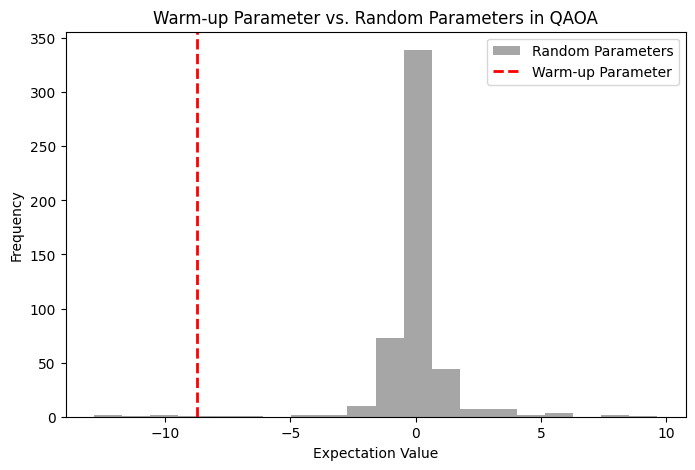

 98.8000% Tensor warm state is better than random state!

Tesnor warm state energy : -8.710873905999009
Mean random state energy : -0.2068055866893711


In [18]:
qaoa = QAOA_layer(depth,Q)
@qml.qnode(qaoa.dev)
def qaoa_expectation(params):
    """
    Quantum node that runs the QAOA circuit and measures the expectation value
    of the cost Hamiltonian.

    Args:
        params (np.ndarray): Array of QAOA parameters (gammas and betas).

    Returns:
        float: Expectation value of the cost Hamiltonian.
    """
    qaoa.qaoa_circuit(params)
    return qml.expval(qaoa.ham)


params = param_list[0]
H = qaoa_expectation(params)

import matplotlib.pyplot as plt

def f(x):
    @qml.qnode(qaoa.dev)
    def qaoa_expectation(params):
        """
        Quantum node that runs the QAOA circuit and measures the expectation value
        of the cost Hamiltonian.

        Args:
            params (np.ndarray): Array of QAOA parameters (gammas and betas).

        Returns:
            float: Expectation value of the cost Hamiltonian.
        """
        qaoa.qaoa_circuit(params)
        return qml.expval(qaoa.ham)
    return qaoa_expectation(x)  # Example function

def visualize_warmup_vs_random(warmup_x, random_x):
    warmup_y = f(warmup_x)
    random_y = np.array([f(x) for x in random_x])
    
    plt.figure(figsize=(8, 5))
    
    # Histogram of f(x) results for random x values
    plt.hist(random_y, bins=20, alpha=0.7, color='gray', label='Random Parameters')
    
    # Marking the f(x) result for warm-up x
    plt.axvline(warmup_y, color='red', linestyle='dashed', linewidth=2, label='Warm-up Parameter')
    
    # Graph settings
    plt.xlabel('Expectation Value')
    plt.ylabel('Frequency')
    plt.title('Warm-up Parameter vs. Random Parameters in QAOA')
    plt.legend()
    plt.show()
    return warmup_y,random_y
# Example data settings
warmup_x = params # Specific warm-up parameter value
random_x = np.random.uniform(-np.pi, np.pi, (500,2 * depth))  # Sampling 500 random x values from the range [-np.pi, np.pi]

warmup_y,random_y = visualize_warmup_vs_random(warmup_x, random_x)

prob = 0
mean_rand_H = 0
for i in range(len(random_y)):
    H_random = random_y[i]
    H = warmup_y
    if H_random>H:
        prob+=1
    mean_rand_H += H_random

mean_rand_H = mean_rand_H/100
prob = prob/len(random_y)*100
print(f' {prob:.4f}% Tensor warm state is better than random state!\n')

print(f'Tesnor warm state energy : {warmup_y}')
print(f'Mean random state energy : {mean_rand_H}')


# **Comparison of RL-QAOA with Warm-Up State vs. Random Initialization**

In this session, we aim to compare the performance of **Reinforcement Learning-based QAOA (RL-QAOA)** under two different initialization strategies:

1. **Warm-Up State Initialization:**  
   - We leverage the pretrained parameters obtained from our previous warm-up process using tensor-network-friendly graphs.
   
2. **Random Initialization:**  
   - The RL-QAOA starts with randomly initialized parameters without any prior knowledge.



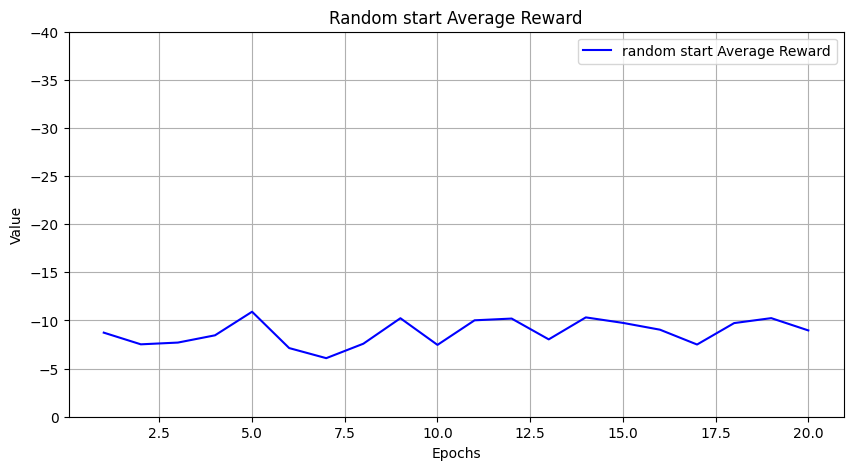
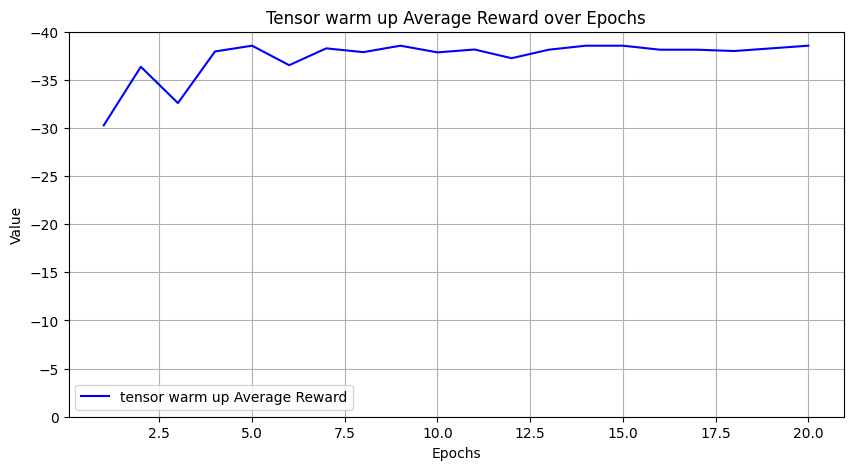
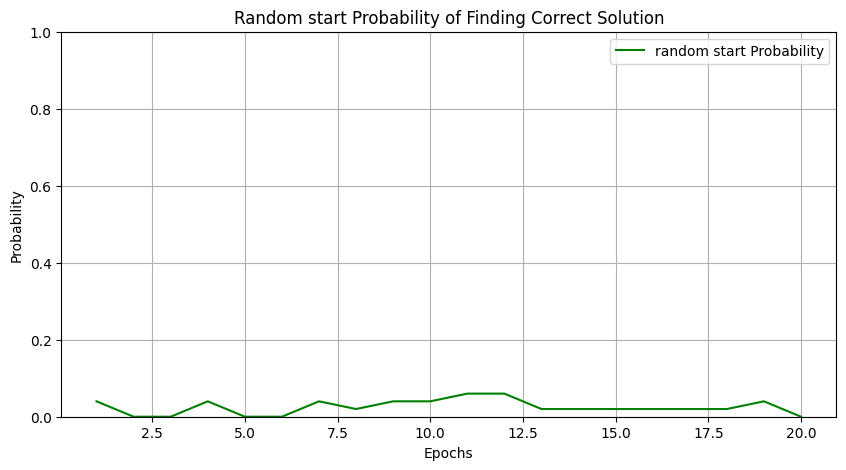
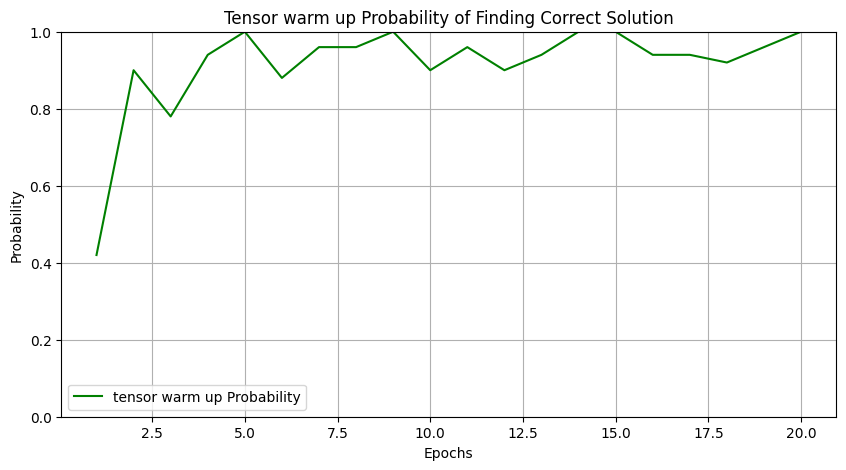


In [19]:
## Optimization with randomstate

# Initial parameters for QAOA
n = Q.shape[0]
n_c = 2

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, 2 * depth*(n-n_c))



# RL-QAOA setup
rl_qaoa_rand = RL_QAOA(Q,n,init_params,b_vector = np.array([25.]*int((n**2))) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.02,0.05])
final_config = rl_qaoa_rand.rqaoa_execute()
rl_qaoa_rand.n_c =n_c
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa_rand.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa_rand.RL_QAOA(episodes=50,epochs=20,correct_ans=float(final_config[2]))

classical_result : -38.548443989732604,best : [1, 1, 1, 1, 1, -1, -1, -1]


Epoch 1/20: 100%|██████████| 50/50 [06:21<00:00,  7.62s/ episode]


  Probability of finding correct solution: 0.0400
  Average reward: -8.735645053940011
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 6/20: 100%|██████████| 50/50 [06:04<00:00,  7.29s/ episode]


  Probability of finding correct solution: 0.0000
  Average reward: -7.132847795059123
  Lowest reward obtained: -31.615793236051026
  Best state at lowest value: [ 1  1  1  1 -1 -1 -1 -1]


Epoch 11/20: 100%|██████████| 50/50 [03:58<00:00,  4.77s/ episode]


  Probability of finding correct solution: 0.0600
  Average reward: -10.017307471240208
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 16/20: 100%|██████████| 50/50 [03:36<00:00,  4.33s/ episode]


  Probability of finding correct solution: 0.0200
  Average reward: -9.042089835786511
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 20/20: 100%|██████████| 50/50 [03:26<00:00,  4.14s/ episode]


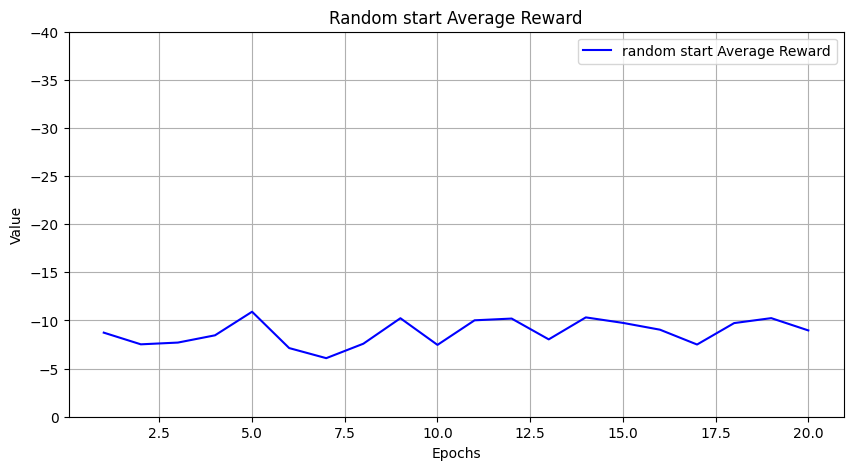

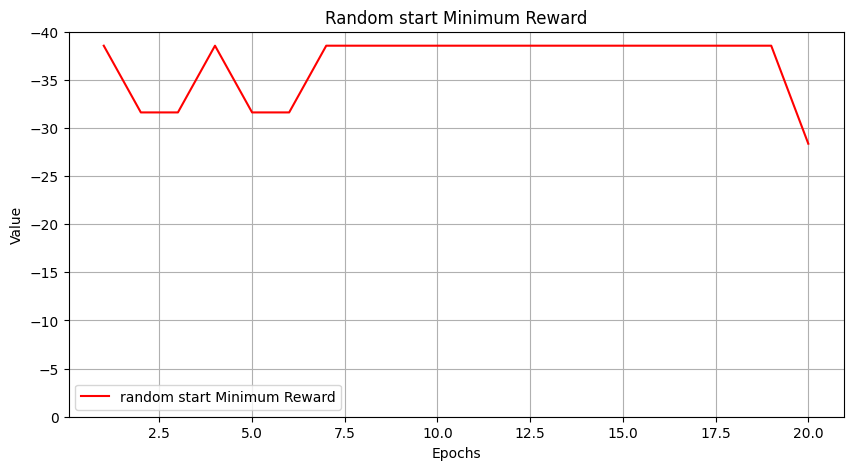

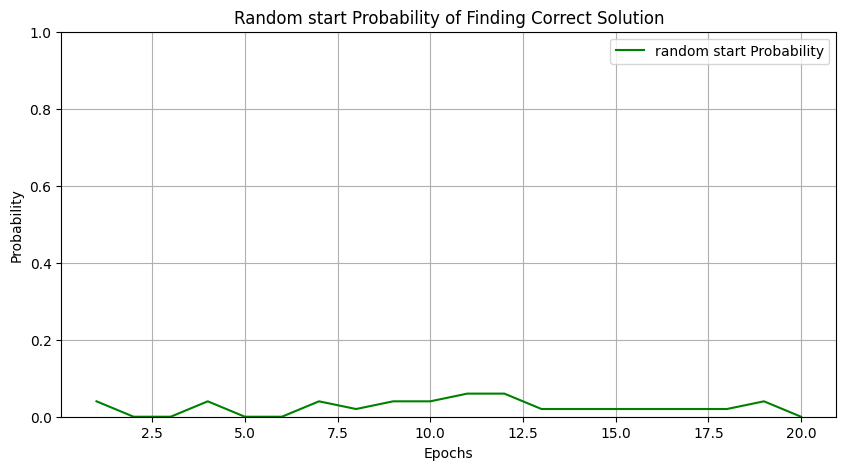

In [20]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="random start Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Random start Average Reward")
    plt.ylim(0,-40)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="random start Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Random start Minimum Reward")
    plt.ylim(0,-40)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="random start Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Random start Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values_random = rl_qaoa_rand.avg_values
min_values_random = rl_qaoa_rand.min_values
prob_values_random = rl_qaoa_rand.prob_values

plot_rl_qaoa_results(avg_values_random, min_values_random, prob_values_random)



In [21]:
## Optimization with tensorwarm state

# Initial parameters for QAOA
init_params = np.array(param_list)
init_params = np.reshape(init_params,(-1))

# RL-QAOA setup
rl_qaoa = RL_QAOA(Q,Q.shape[0],init_params,b_vector = np.array([25.]*int((Q.shape[0]**2))) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.02,0.05])
final_config = rl_qaoa.rqaoa_execute()
rl_qaoa.n_c = 2
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa.RL_QAOA(episodes=50,epochs=20,correct_ans=float(final_config[2]))

classical_result : -38.548443989732604,best : [1, 1, 1, 1, 1, -1, -1, -1]


Epoch 1/20: 100%|██████████| 50/50 [03:25<00:00,  4.11s/ episode]


  Probability of finding correct solution: 0.4200
  Average reward: -30.274285685108556
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 6/20: 100%|██████████| 50/50 [03:56<00:00,  4.73s/ episode]


  Probability of finding correct solution: 0.8800
  Average reward: -36.524318357024555
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 11/20: 100%|██████████| 50/50 [03:42<00:00,  4.45s/ episode]


  Probability of finding correct solution: 0.9600
  Average reward: -38.15150811053041
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 16/20: 100%|██████████| 50/50 [03:28<00:00,  4.18s/ episode]


  Probability of finding correct solution: 0.9400
  Average reward: -38.13248494451171
  Lowest reward obtained: -38.548443989732604
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 20/20: 100%|██████████| 50/50 [03:32<00:00,  4.25s/ episode]


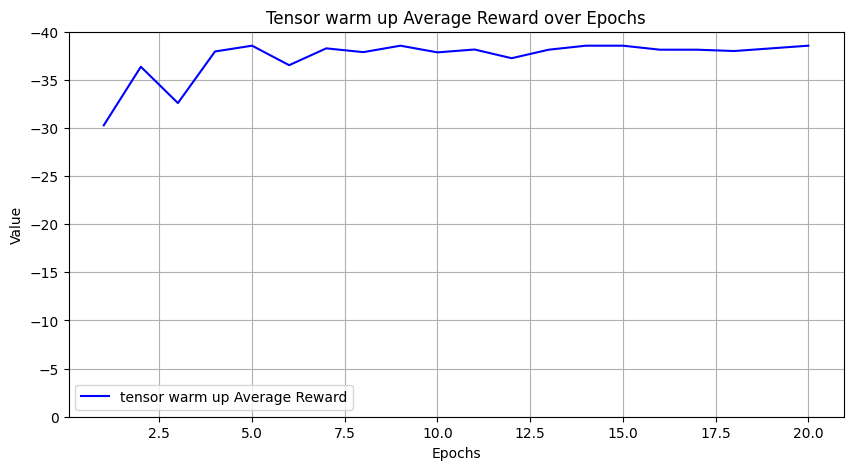

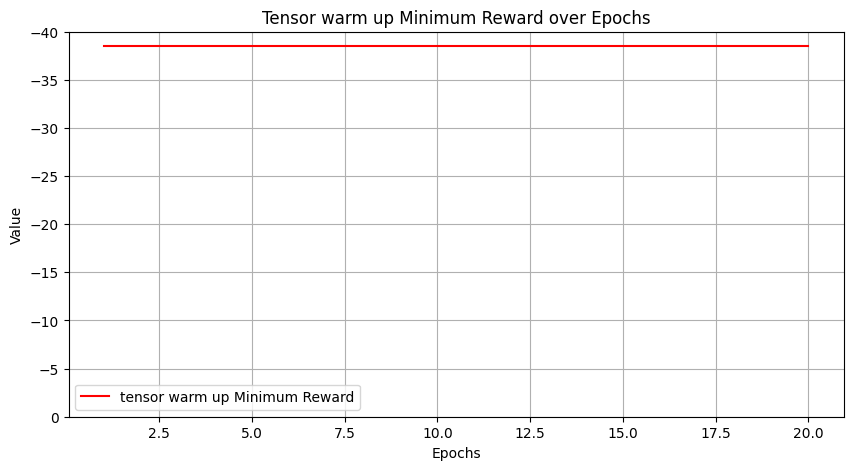

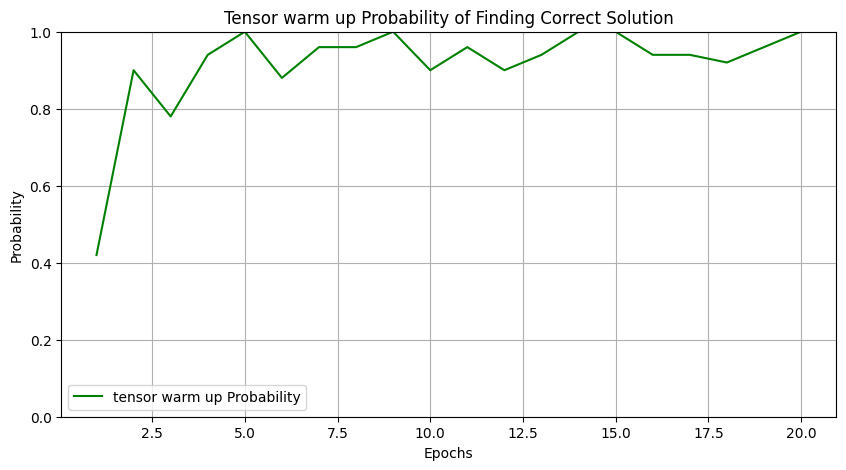

In [22]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="tensor warm up Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Tensor warm up Average Reward over Epochs")
    plt.ylim(0,-40)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="tensor warm up Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Tensor warm up Minimum Reward over Epochs")
    plt.ylim(0,-40)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="tensor warm up Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Tensor warm up Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values = rl_qaoa.avg_values
min_values = rl_qaoa.min_values
prob_values = rl_qaoa.prob_values

plot_rl_qaoa_results(avg_values, min_values, prob_values)
